In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, split, when, countDistinct, max
from pyspark.sql.window import Window
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# create SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("eCommerce_behavior_data_analysis") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .config("spark.executor.heartbeatInterval", "900s") \
    .config("spark.network.timeout", "1000s") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()

In [4]:
df = spark.read.csv("hdfs://localhost:9000/BigData/2019-Oct.csv", header=True, inferSchema=True)
df.show(5)


+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 02:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 02:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 02:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 02:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 02:00:04|      view|   1004237|2053013555631882655|electr

In [5]:
df.printSchema()


root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [6]:
# check missing values
missing_values = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
print('Missing Values:')
missing_values.show()

Missing Values:
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     13515609|6113008|    0|      0|           2|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [7]:
duplicates = df.groupBy(df.columns) \
    .count() \
    .filter(col("count") > 1)

duplicates_count = duplicates.count()

print(f"Number of Duplicates: {duplicates_count}")
duplicates.show(10)

Number of Duplicates: 18099
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|count|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+-----+
|2019-10-01 16:44:59|      cart|   1801806|2053013554415534427|electronics.video.tv|  artel| 124.4|551484167|cbea1412-7f08-476...|    4|
|2019-10-01 10:32:16|      view|   2600519|2053013563970159485|                NULL| gefest|166.28|555549288|35785d30-1ba0-44b...|    2|
|2019-10-02 05:03:10|      cart|  30000074|2127425436764865054|construction.tool...|eurolux| 99.62|535333026|f492aac9-9ce1-4ba...|    2|
|2019-10-02 10:42:47|      cart|   1004767|2053013555631882655|electronics.smart...|samsung|253.05|543076049|5f099d9f-bd48-40d...|    2|
|2019-10-02 1

In [5]:
df = df.dropDuplicates()

In [ ]:

duplicates = df.groupBy(df.columns) \
    .count() \
    .filter(col("count") > 1)

duplicates_count = duplicates.count()

print(f"Number of Duplicates: {duplicates_count}")

Number of Duplicates: 0


In [9]:
event_type = df.select('event_type').distinct()
event_type.show()


+----------+
|event_type|
+----------+
|  purchase|
|      view|
|      cart|
+----------+



In [10]:
# calculate the global conversion rate
global_funnel = df.groupBy("event_type").agg(count("*").alias("event_count"))

total_views = global_funnel.filter(col("event_type") == "view").select("event_count").collect()[0][0]
total_carts = global_funnel.filter(col("event_type") == "cart").select("event_count").collect()[0][0]
total_purchases = global_funnel.filter(col("event_type") == "purchase").select("event_count").collect()[0][0]

view_to_cart_rate = total_carts / total_views
cart_to_purchase_rate = total_purchases / total_carts
overall_conversion_rate = total_purchases / total_views

print(f"View to Cart Rate: {view_to_cart_rate:.2%}")
print(f"Cart to Purchase Rate: {cart_to_purchase_rate:.2%}")
print(f"Overall Conversion Rate: {overall_conversion_rate:.2%}")

View to Cart Rate: 2.20%
Cart to Purchase Rate: 82.67%
Overall Conversion Rate: 1.82%


In [7]:
df_categories = df.withColumn("category_main", split(col("category_code"), r"\.").getItem(0))
    
df_no_nulls = df_categories.filter(col("category_code").isNotNull())

# Check if main categories are correctly extracted
df_no_nulls.select("category_code", "category_main").show(10)

+--------------------+-------------+
|       category_code|category_main|
+--------------------+-------------+
|electronics.audio...|  electronics|
|construction.tool...| construction|
|electronics.smart...|  electronics|
|appliances.kitche...|   appliances|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|electronics.smart...|  electronics|
|  electronics.clocks|  electronics|
+--------------------+-------------+
only showing top 10 rows



In [8]:
category_main_count = df_no_nulls.groupBy("category_main").agg(countDistinct("product_id").alias("product_count"))
category_main_count.show()

# calculate total products
total_products = df_no_nulls.select(countDistinct("product_id")).collect()[0][0]

# calculate the ratio of each product
category_main_ratio = category_main_count.withColumn("product_ratio", col("product_count") / total_products)

category_main_ratio.show()

+-------------+-------------+
|category_main|product_count|
+-------------+-------------+
|     medicine|           29|
|    computers|         7930|
|         auto|         1201|
|   stationery|          607|
|        sport|         2157|
|      apparel|        13417|
|   appliances|        12362|
| country_yard|          185|
|    furniture|         6972|
|  accessories|         2516|
|         kids|         5123|
|  electronics|        14950|
| construction|         5701|
+-------------+-------------+

+-------------+-------------+--------------------+
|category_main|product_count|       product_ratio|
+-------------+-------------+--------------------+
|     medicine|           29|3.964456596035543...|
|    computers|         7930| 0.10840738209159262|
|         auto|         1201|0.016418318523581683|
|   stationery|          607|0.008298017771701981|
|        sport|         2157|0.029487354750512645|
|      apparel|        13417| 0.18341763499658237|
|   appliances|        12362| 

In [ ]:
category_main_ratio_pd = category_main_ratio.toPandas()

mainCat_names = category_main_ratio_pd["category_main"]
mainCat_values = category_main_ratio_pd["product_ratio"]

plt.figure(figsize=(6, 6))
plt.pie(mainCat_values, labels=mainCat_names, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Main Category Distribution")
plt.show()

In [9]:
category_funnel = df_no_nulls.groupBy("category_main", "event_type").agg(countDistinct("product_id").alias("product_count"))
category_funnel.show(10)

window_spec = Window.partitionBy("category_main")
category_conversion = category_funnel.withColumn("total_views", sum(col("product_count")).over(window_spec)) \
    .filter(col("event_type") == "purchase") \
    .withColumn("conversion_rate", col("product_count") / col("total_views")) \
    .select("category_main", "conversion_rate")

category_conversion.show(10)

+-------------+----------+-------------+
|category_main|event_type|product_count|
+-------------+----------+-------------+
|   appliances|  purchase|         4838|
|   stationery|      cart|           34|
|        sport|  purchase|          270|
| construction|  purchase|          939|
|   appliances|      cart|         2852|
|         auto|      cart|          167|
|    furniture|      cart|          218|
|  accessories|  purchase|          554|
|  electronics|  purchase|         4698|
|    computers|      cart|         1285|
+-------------+----------+-------------+
only showing top 10 rows

+-------------+-------------------+
|category_main|    conversion_rate|
+-------------+-------------------+
|  accessories|0.17399497487437185|
|      apparel|0.15754154907494514|
|   appliances| 0.2412726910033912|
|         auto|0.30804248861911987|
|    computers|0.22255968953007677|
| construction| 0.1347782402755849|
| country_yard|0.13063063063063063|
|  electronics|0.21801475706529305|
|   

# Session Analysis & Feature Engineering

In [6]:
from pyspark.sql import functions as F


# filter out rows where 'user_session' is null 
df_sessions = df.filter(F.col("user_session").isNotNull())

# group by 'user_session' and aggregate the minimum and maximum 'event_time' per session
# - Compute the session start (minimum event time) and end (maximum event time)
# - Count the number of purchase events per session

session_df = df_sessions.groupBy("user_session").agg(
    F.min("event_time").alias("session_start"),
    F.max("event_time").alias("session_end"),
    F.sum(F.when(F.col("event_type") == "purchase", 1).otherwise(0)).alias("purchase_count")
)


In [7]:
# Define thresholds for session duration classification (in minutes)
SHORT_THRESHOLD = 5    # Sessions with duration <= 5 minutes are considered 'Short'
LONG_THRESHOLD = 30    # Sessions with duration > 30 minutes are considered 'Long'


# Calculate session duration in minutes.
# This converts the 'session_start' and 'session_end' timestamps to Unix time (seconds since epoch),
# subtracts to get the duration in seconds, and then converts to minutes.
session_df = session_df.withColumn("session_duration_min", 
    (F.unix_timestamp("session_end") - F.unix_timestamp("session_start")) / 60.0
)

# Classify sessions based on the duration:
# - 'Short' if duration is <= SHORT_THRESHOLD minutes.
# - 'Long' if duration is > LONG_THRESHOLD minutes.
# - 'Medium' otherwise.
session_df = session_df.withColumn("session_category",
    F.when(F.col("session_duration_min") <= SHORT_THRESHOLD, "Short")
     .when(F.col("session_duration_min") > LONG_THRESHOLD, "Long")
     .otherwise("Medium")
)

# Create a binary flag 'converted' where a session is marked as 1 if at least one purchase was made,
# and 0 otherwise.
session_df = session_df.withColumn("converted", F.when(F.col("purchase_count") > 0, 1).otherwise(0))


In [8]:
# Display the session data
session_df.select("user_session", "session_duration_min", "session_category", "converted", "session_start", "session_end", "purchase_count").show(10, truncate=False)

+------------------------------------+--------------------+----------------+---------+-------------------+-------------------+--------------+
|user_session                        |session_duration_min|session_category|converted|session_start      |session_end        |purchase_count|
+------------------------------------+--------------------+----------------+---------+-------------------+-------------------+--------------+
|fb94af5f-bf82-4751-97e4-74247fb5910e|0.0                 |Short           |0        |2019-10-01 06:19:37|2019-10-01 06:19:37|0             |
|6be39caf-02d5-4e2c-935f-83808c4e9eb5|12.583333333333334  |Medium          |0        |2019-10-01 12:44:00|2019-10-01 12:56:35|0             |
|e613e971-3fa9-4738-86ec-f1aacf106c89|25.416666666666668  |Medium          |0        |2019-10-01 12:54:59|2019-10-01 13:20:24|0             |
|7d29ddb2-a9c3-4b86-8ed3-1e4205e5bd3a|21.633333333333333  |Medium          |0        |2019-10-01 13:25:42|2019-10-01 13:47:20|0             |
|a03bd

In [9]:
session_df.printSchema()


root
 |-- user_session: string (nullable = true)
 |-- session_start: timestamp (nullable = true)
 |-- session_end: timestamp (nullable = true)
 |-- purchase_count: long (nullable = true)
 |-- session_duration_min: double (nullable = true)
 |-- session_category: string (nullable = false)
 |-- converted: integer (nullable = false)



In [10]:

# Group by session category to compute:
# - The total number of sessions
# - The number of sessions that converted (had at least one purchase)
# Then, calculate the conversion rate as a percentage.
conversion_df = session_df.groupBy("session_category").agg(
    F.count("user_session").alias("total_sessions"),
    F.sum("converted").alias("converted_sessions")
).withColumn("conversion_rate", 
    F.col("converted_sessions") / F.col("total_sessions") * 100
)

# order the results by session category for better readability.
conversion_df = conversion_df.orderBy("session_category")

# Show the conversion rates per session category.
conversion_df.show()


+----------------+--------------+------------------+------------------+
|session_category|total_sessions|converted_sessions|   conversion_rate|
+----------------+--------------+------------------+------------------+
|            Long|        295161|             31363|  10.6257262985286|
|          Medium|       1830982|            239525|13.081777974879055|
|           Short|       7118278|            358672| 5.038746730599732|
+----------------+--------------+------------------+------------------+



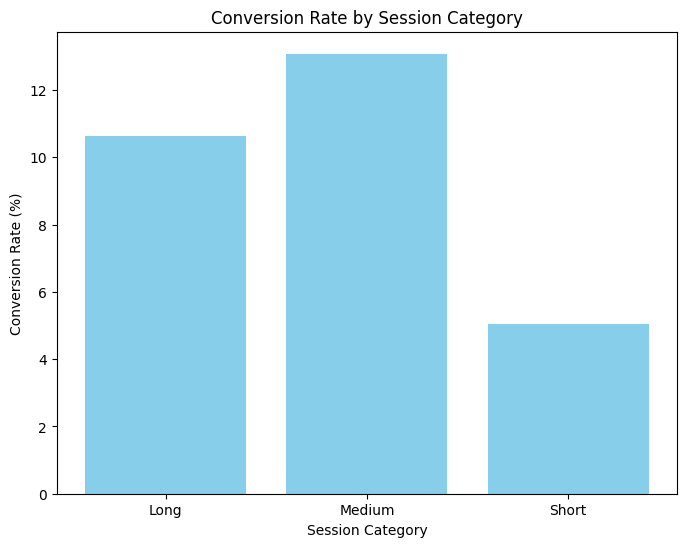

In [11]:
# Convert the Spark DataFrame to a Pandas DataFrame for visualization.
conversion_pd = conversion_df.toPandas()


# Create a bar chart to compare conversion rates by session category.
plt.figure(figsize=(8, 6))
plt.bar(conversion_pd["session_category"], conversion_pd["conversion_rate"], color='skyblue')
plt.xlabel("Session Category")
plt.ylabel("Conversion Rate (%)")
plt.title("Conversion Rate by Session Category")
plt.show()
